Unfortunately, Neural Networks don’t understand text data. To deal with the issue, you must figure out a way to convert text into numbers. There are a variety of ways to solve the problem, but most well-performing models use Embeddings. <br>
source: https://curiousily.com/posts/sentiment-analysis-with-tensorflow-2-and-keras-using-python/

### Hotel Reviews dataset
https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe

In [1]:
# Download the dataset directly from google drive
!gdown --id 1tePKK3szVUuzewJNwLRbwDgJjkEnZWNf

Downloading...
From: https://drive.google.com/uc?id=1tePKK3szVUuzewJNwLRbwDgJjkEnZWNf
To: /content/Hotel_Reviews.csv
238MB [00:04, 50.4MB/s]


In [2]:
import pandas as pd

df = pd.read_csv("Hotel_Reviews.csv", parse_dates=['Review_Date'])

In [3]:
df.head(3)

Hotel_Address  ...       lng
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...  ...  4.915968
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...  ...  4.915968
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...  ...  4.915968

[3 rows x 17 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Hotel_Address                               515738 non-null  object        
 1   Additional_Number_of_Scoring                515738 non-null  int64         
 2   Review_Date                                 515738 non-null  datetime64[ns]
 3   Average_Score                               515738 non-null  float64       
 4   Hotel_Name                                  515738 non-null  object        
 5   Reviewer_Nationality                        515738 non-null  object        
 6   Negative_Review                             515738 non-null  object        
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64         
 8   Total_Number_of_Reviews                     515738 non-null  int64        

There are a lot of information to be consider but this work we are considering only review text and review score.

In [5]:
df["review"] = df["Negative_Review"] + df["Positive_Review"]
df["review_type"] = df["Reviewer_Score"].apply(
    lambda x: "bad" if x < 7 else "good"
)

df = df[["review", "review_type"]]

#### Exploring the dataset

In [6]:
df.review_type.value_counts()

good    428887
bad      86851
Name: review_type, dtype: int64

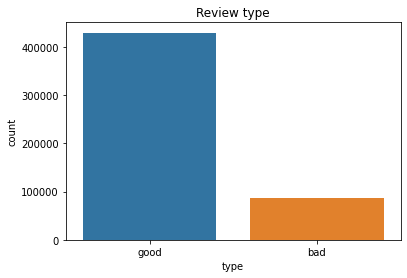

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(
  x='review_type',
  data=df,
  order=df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type");

In [8]:
good_reviews = df[df.review_type == "good"]
bad_reviews = df[df.review_type == "bad"]

print(good_reviews.shape, bad_reviews.shape)

(428887, 2) (86851, 2)


In [9]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

good_reviews_text = " ".join(good_reviews.review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.review.to_numpy().tolist())

good_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(good_reviews_text)
bad_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(bad_reviews_text)

In [10]:
def show_word_cloud(cloud, title):
  plt.figure(figsize = (16, 10), dpi=300)
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show()

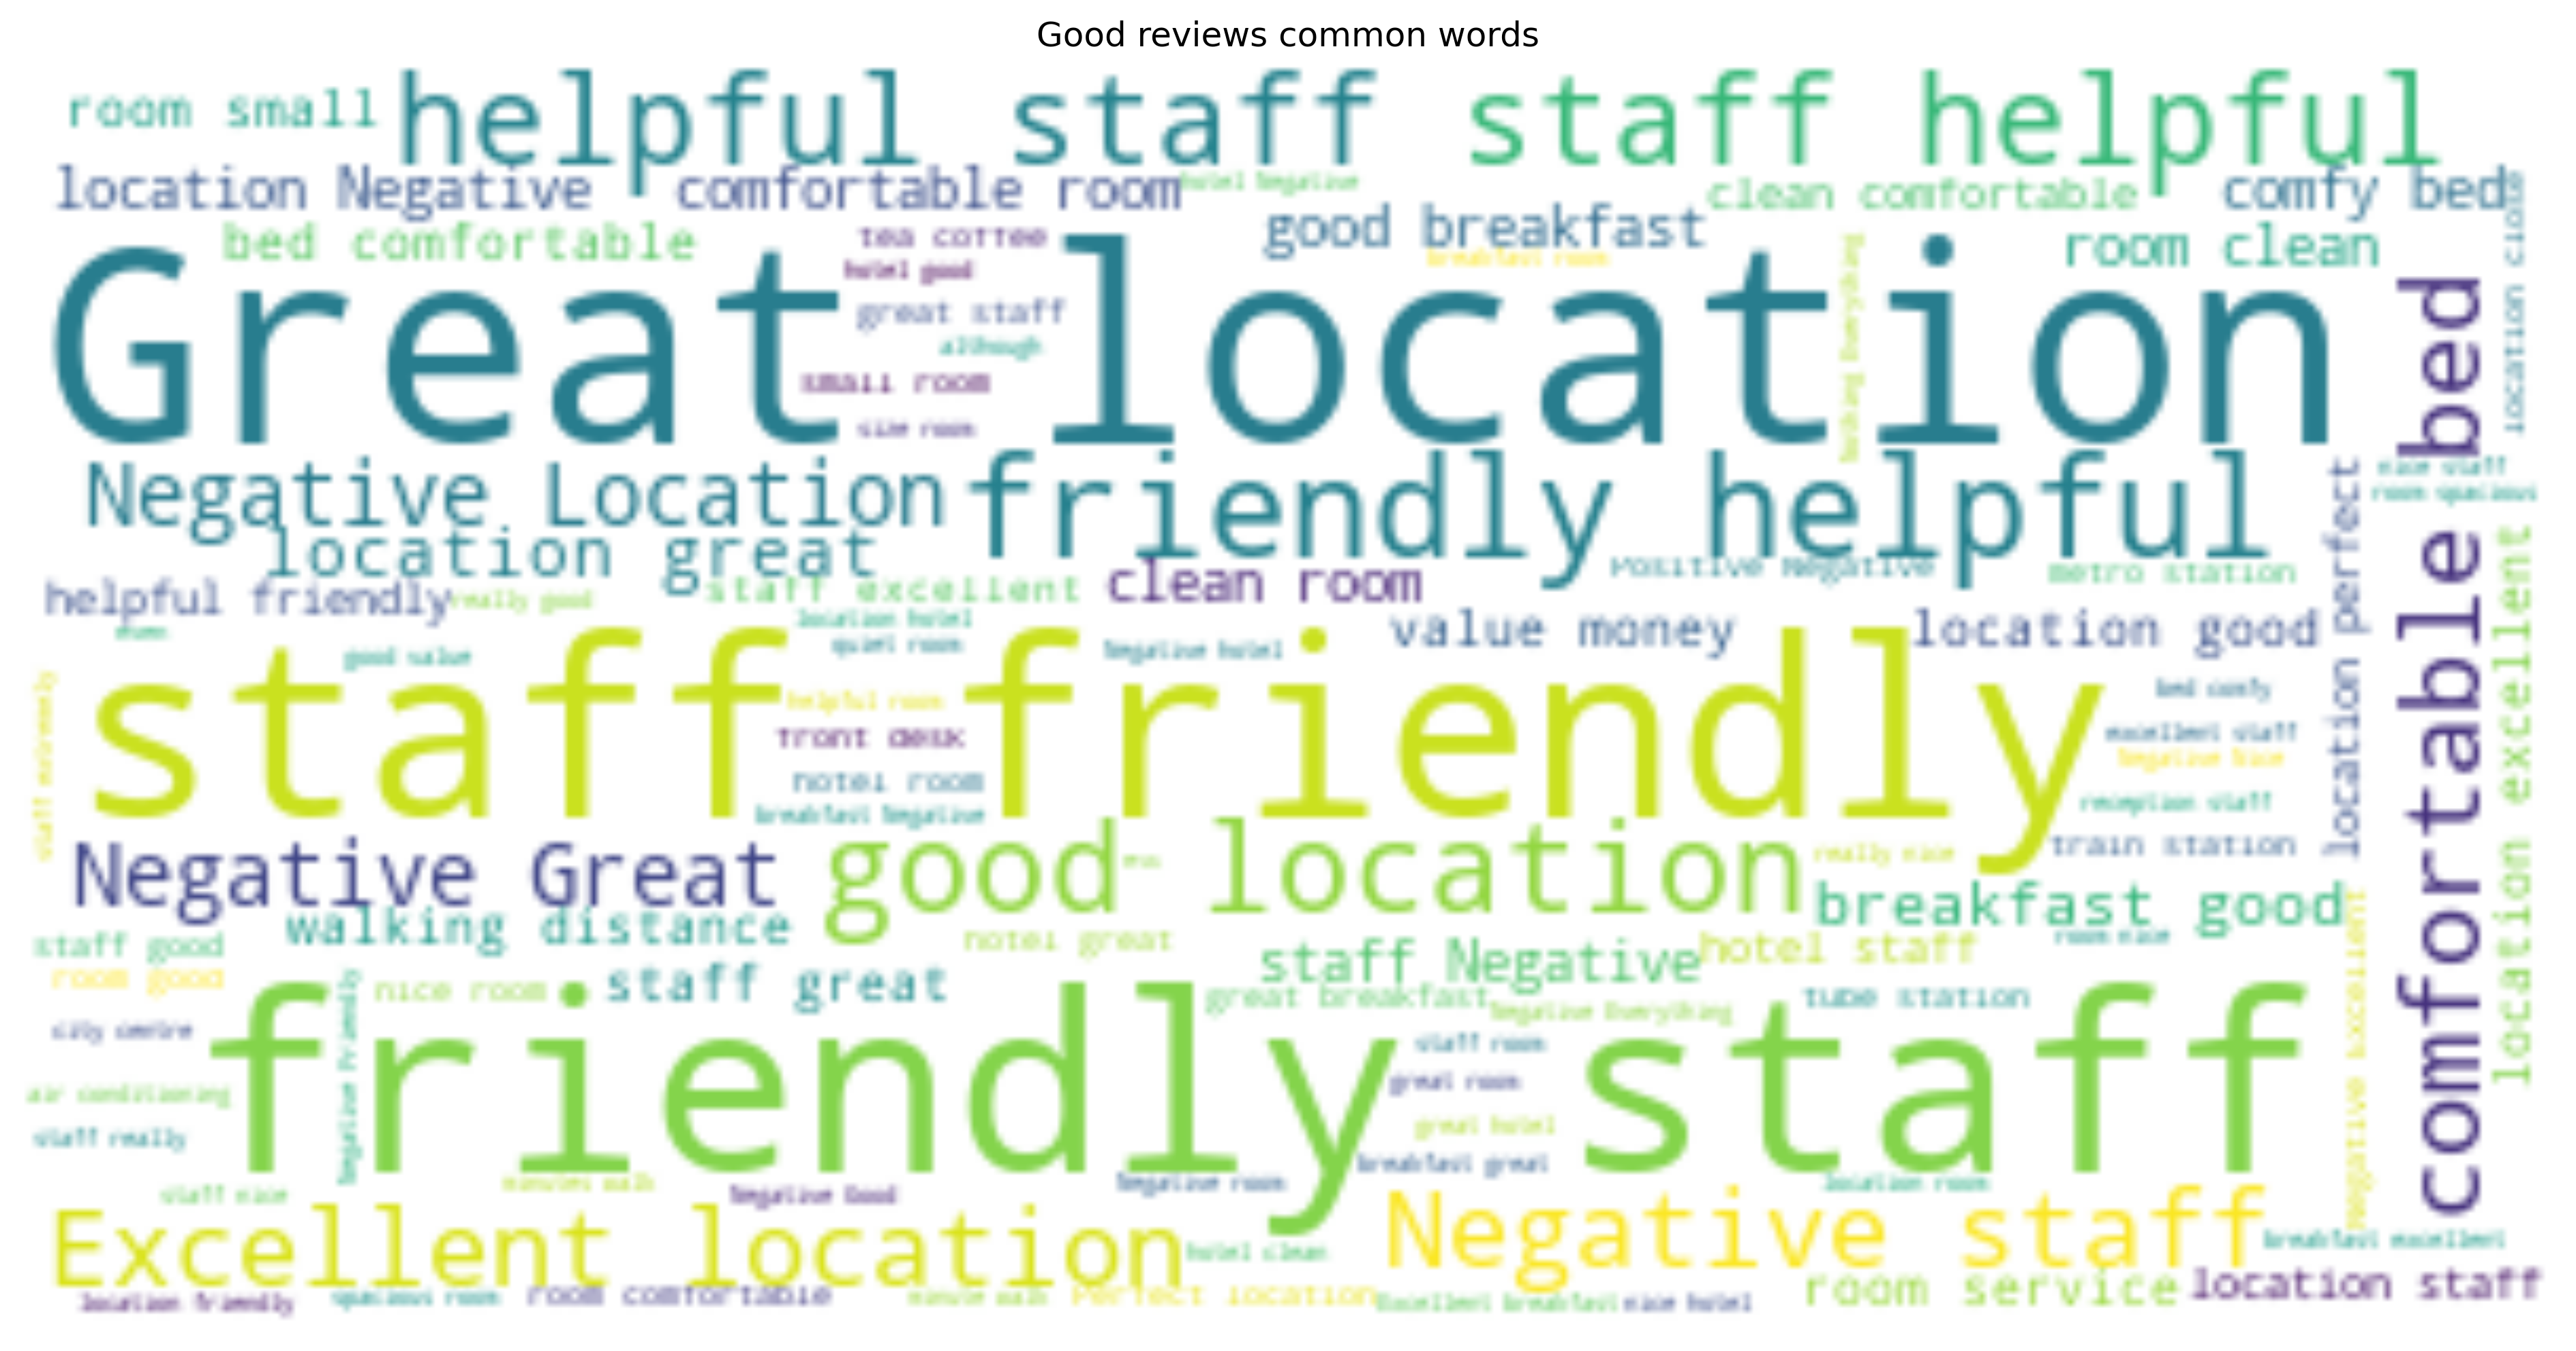

In [11]:
show_word_cloud(good_reviews_cloud, "Good reviews common words")

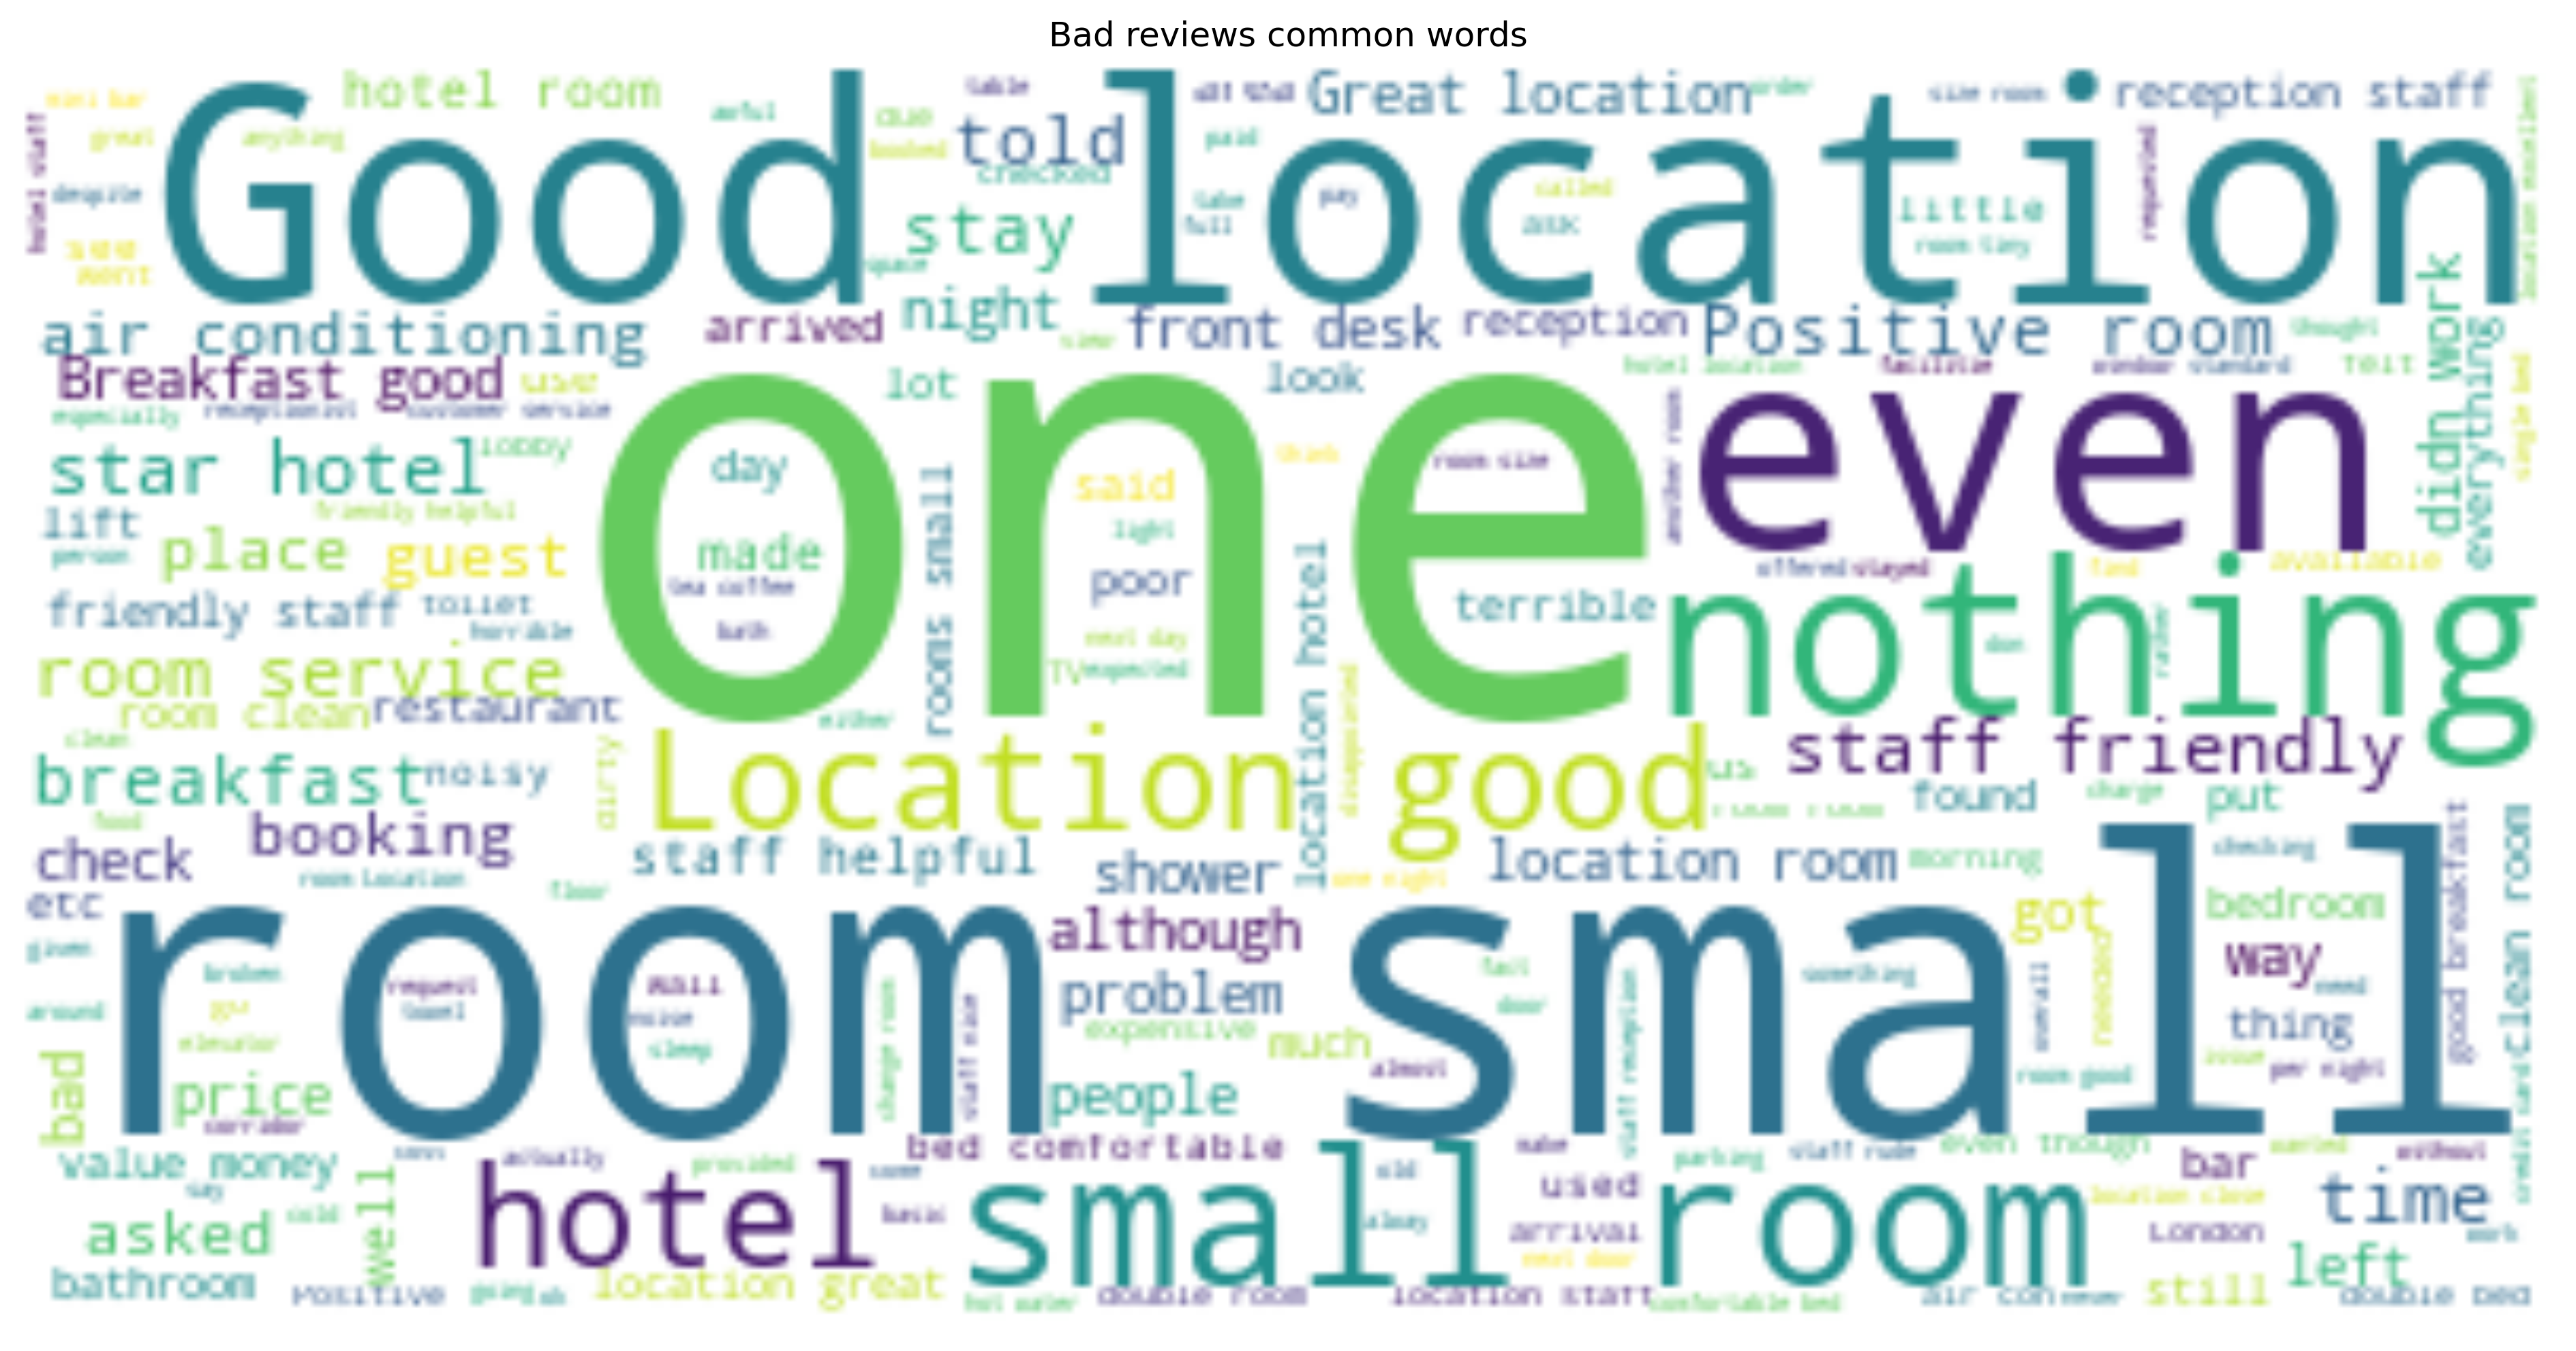

In [12]:
show_word_cloud(bad_reviews_cloud, "Bad reviews common words")

### Data Wrangling/Data Cleansing
Reduce the size of good reviews equal to bad reviews

In [13]:
good_df = good_reviews.sample(n=len(bad_reviews))
bad_df = bad_reviews

In [14]:
print(good_df.shape, bad_df.shape)

(86851, 2) (86851, 2)


In [15]:
review_df = good_df.append(bad_df).reset_index(drop=True)
review_df.shape

(173702, 2)

In [16]:
review_df.head()

review review_type
0   If being really picky then would say that I w...        good
1   The beds were too high and the rooms a little...        good
2   The room was small and shower room was as wel...        good
3   Had a meal in restaurant first night had to s...        good
4  No Negative We had our room already available ...        good

Text(0.5, 1.0, 'Review type (resampled)')

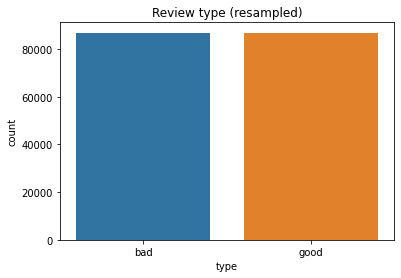

In [17]:
sns.countplot(
  x='review_type',
  data=review_df,
  order=review_df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)")

### Data Preprocessing

In [18]:
# One Hot encoding
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  review_df.review_type.to_numpy().reshape(-1, 1)
)

In [19]:
from sklearn.model_selection import train_test_split

# Train and Test split data
train_reviews, test_reviews, y_train, y_test =\
  train_test_split(
    review_df.review, 
    type_one_hot, 
    test_size=.1,
  )

### Universal Sentence Encoder
[Paper about Universal Sentence Encoder](https://arxiv.org/abs/1803.11175)
Instead of we use manual embedding, why not we use the [existing one](https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3) from tensorflow. <br>
![](https://www.gstatic.com/aihub/tfhub/universal-sentence-encoder/example-classification.png)
The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.

In [20]:
!pip install tensorflow_text>=2.0.0rc0

In [21]:
import tensorflow_hub as hub
import tensorflow_text

# source: https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder
# source: https://tfhub.dev/google/universal-sentence-encoder-multilingual/3
# More read: https://amitness.com/2020/06/universal-sentence-encoder/
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

In [22]:
# Example
sent_1 = ["the location is great"]
emb_1 = use(sent_1)
emb_1.shape

TensorShape([1, 512])

In [23]:
# Encoding
from tqdm import tqdm
import numpy as np
import tensorflow as tf

X_train = []
for r in tqdm(train_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 156331/156331 [18:34<00:00, 140.32it/s]


In [24]:
X_test = []
for r in tqdm(test_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 17371/17371 [02:05<00:00, 138.47it/s]


In [25]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(156331, 512) (156331, 2) (17371, 512) (17371, 2)


### Sentiment Analysis

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout

# Define the neural network
model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(128, activation='relu'),
    Dropout(rate=0.5),
    Dense(2, activation='softmax')
])

In [27]:
from tensorflow import keras

model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 164,482
Trainable params: 164,482
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
8794/8794 [==============================] - 23s 3ms/step - loss: 0.4397 - accuracy: 0.7909 - val_loss: 0.4300 - val_accuracy: 0.8011
Epoch 2/10
8794/8794 [==============================] - 23s 3ms/step - loss: 0.4150 - accuracy: 0.8060 - val_loss: 0.4237 - val_accuracy: 0.8020
Epoch 3/10
8794/8794 [==============================] - 22s 3ms/step - loss: 0.4005 - accuracy: 0.8143 - val_loss: 0.4177 - val_accuracy: 0.8061
Epoch 4/10
8794/8794 [==============================] - 23s 3ms/step - loss: 0.3871 - accuracy: 0.8212 - val_loss: 0.4194 - val_accuracy: 0.8031
Epoch 5/10
8794/8794 [==============================] - 23s 3ms/step - loss: 0.3733 - accuracy: 0.8289 - val_loss: 0.4226 - val_accuracy: 0.8056
Epoch 6/10
8794/8794 [==============================] - 24s 3ms/step - loss: 0.3583 - accuracy: 0.8367 - val_loss: 0.4369 - val_accuracy: 0.8070
Epoch 7/10
8794/8794 [==============================] - 23s 3ms/step - loss: 0.3422 - accuracy: 0.8448 - val_loss: 0.4477 - val_ac

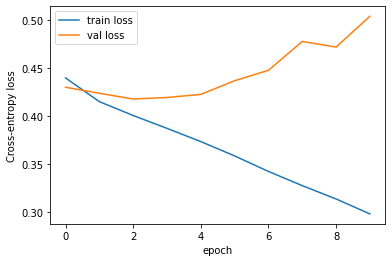

In [29]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend()

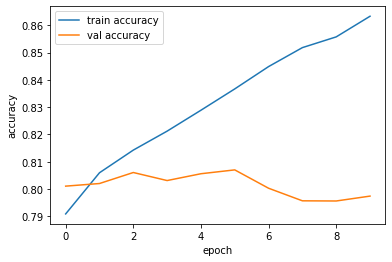

In [30]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

#### Add one more dropout to avoid overfitting

In [31]:
# Define the new neural network with reducing the overfitting
model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(rate=0.5),
    Dense(128, activation='relu'),
    Dropout(rate=0.5),
    Dense(2, activation='softmax')
])

In [33]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 164,482
Trainable params: 164,482
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
8794/8794 [==============================] - 24s 3ms/step - loss: 0.4525 - accuracy: 0.7838 - val_loss: 0.4330 - val_accuracy: 0.7983
Epoch 2/10
8794/8794 [==============================] - 24s 3ms/step - loss: 0.4330 - accuracy: 0.7958 - val_loss: 0.4241 - val_accuracy: 0.8019
Epoch 3/10
8794/8794 [==============================] - 24s 3ms/step - loss: 0.4252 - accuracy: 0.8015 - val_loss: 0.4194 - val_accuracy: 0.8043
Epoch 4/10
8794/8794 [==============================] - 23s 3ms/step - loss: 0.4192 - accuracy: 0.8051 - val_loss: 0.4210 - val_accuracy: 0.8049
Epoch 5/10
8794/8794 [==============================] - 24s 3ms/step - loss: 0.4133 - accuracy: 0.8079 - val_loss: 0.4181 - val_accuracy: 0.8051
Epoch 6/10
8794/8794 [==============================] - 23s 3ms/step - loss: 0.4090 - accuracy: 0.8105 - val_loss: 0.4204 - val_accuracy: 0.8076
Epoch 7/10
8794/8794 [==============================] - 24s 3ms/step - loss: 0.4039 - accuracy: 0.8136 - val_loss: 0.4153 - val_ac

In [35]:
print(model.metrics_names)
model.evaluate(X_test, y_test)

['loss', 'accuracy']
543/543 [==============================] - 1s 2ms/step - loss: 0.4017 - accuracy: 0.8146


[0.401684045791626, 0.8145760297775269]

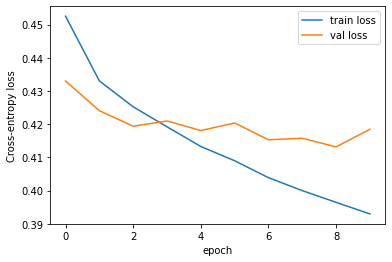

In [36]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend()

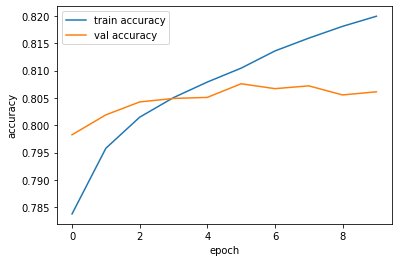

In [37]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

### Make prediction

In [38]:
print(test_reviews.iloc[0])
print("Bad" if y_test[0][0] == 1 else "Good")

 Small rooms Comfortable beds Good Service
Good


In [39]:
y_pred = model.predict(X_test[:1])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[0.35641733 0.64358264]]


'Good'

In [40]:
print(test_reviews.iloc[1])
print("Bad" if y_test[1][0] == 1 else "Good")

No Negative Amazing location very modern and hip room also very comfortable 
Good


In [41]:
y_pred = model.predict(X_test[1:2])
print(y_pred)
print("Bad" if np.argmax(y_pred) == 0 else "Good")

[[0.00173432 0.9982657 ]]
Good


In [42]:
print(test_reviews.iloc[5])
print("Bad" if y_test[5][0] == 1 else "Good")

 The bed was not as comfortable for a higher end hotel  The location was great as well as the atmosphere of the Hotel 
Good


In [43]:
y_pred = model.predict(X_test[5:6])
print(y_pred)
print("Bad" if np.argmax(y_pred) == 0 else "Good")

[[0.35745123 0.6425488 ]]
Good
